In [411]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error

In [225]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [226]:
mbd_data.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,pct_bb,median_hh_inc,pct_college,pct_foreign_born,pct_it_workers
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,76.6,0.282001,14.5,2.1,1.3
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,76.6,0.282001,14.5,2.1,1.3
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,76.6,0.282001,14.5,2.1,1.3
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,76.6,0.282001,14.5,2.1,1.3
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,76.6,0.282001,14.5,2.1,1.3


In [227]:
# decomposition of time series  

In [228]:
samples = []

for key in cluster_keys:
    cfip = np.random.choice(clusters[key])
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    sample = mbd_data[ mbd_data.cfips == cfip].microbusiness_density.values
    samples.append( [cfip, location, sample] )

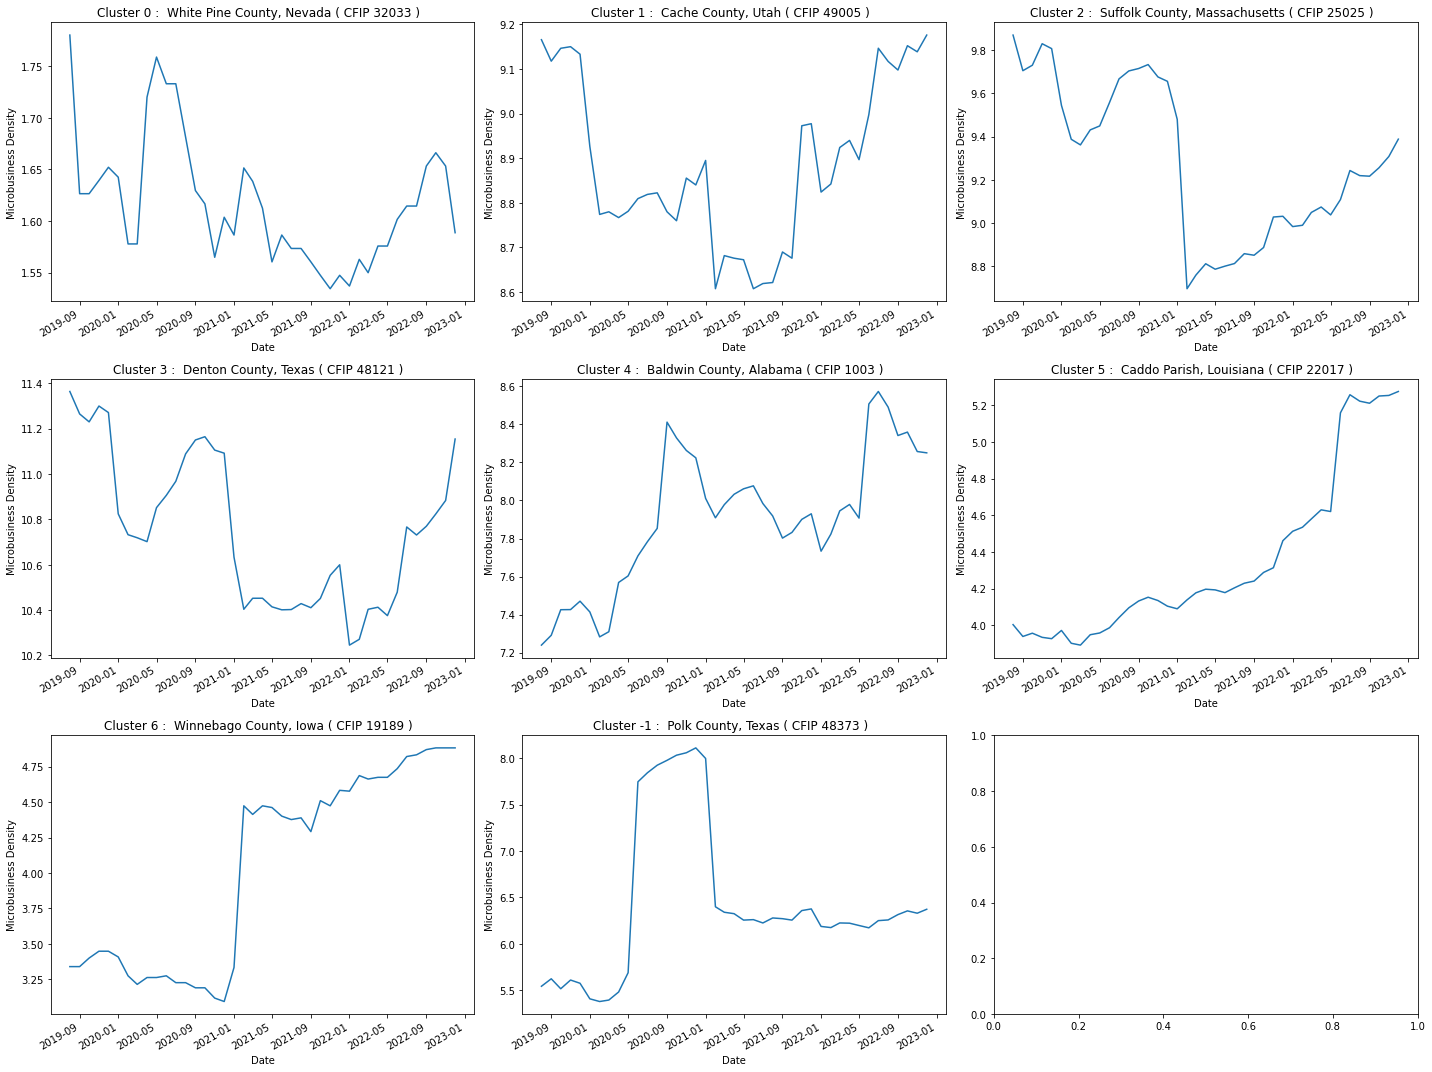

In [229]:
fig, ax = plt.subplots(3,3,figsize=(20,15))
for i, (cfip,location, sample) in enumerate(samples):
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')        
    # Plot the line
    ax[i//3, i%3].plot(dates, sample)

    # Set the axis labels and title
    ax[i//3, i%3].set_xlabel('Date')
    ax[i//3, i%3].set_ylabel('Microbusiness Density')
    ax[i//3, i%3].set_title(f'Cluster {cluster_keys[i]} :  {location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax[i//3, i%3].get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()


In [230]:
import matplotlib.pyplot as plt
import pandas as pd

df = mbd_data.loc[:,['pct_bb', 'median_hh_inc',
       'pct_college', 'pct_foreign_born', 'pct_it_workers','microbusiness_density']].corr()
df

,pct_bb,median_hh_inc,pct_college,pct_foreign_born,pct_it_workers,microbusiness_density
pct_bb,1.000000,0.730531,0.653872,0.281370,0.280274,0.354072
median_hh_inc,0.730531,1.000000,0.709317,0.376521,0.310816,0.374691
pct_college,0.653872,0.709317,1.000000,0.328025,0.369893,0.474409
pct_foreign_born,0.281370,0.376521,0.328025,1.000000,0.210427,0.274378
pct_it_workers,0.280274,0.310816,0.369893,0.210427,1.000000,0.252282
microbusiness_density,0.354072,0.374691,0.474409,0.274378,0.252282,1.000000


In [231]:
## Decomposition of time series 

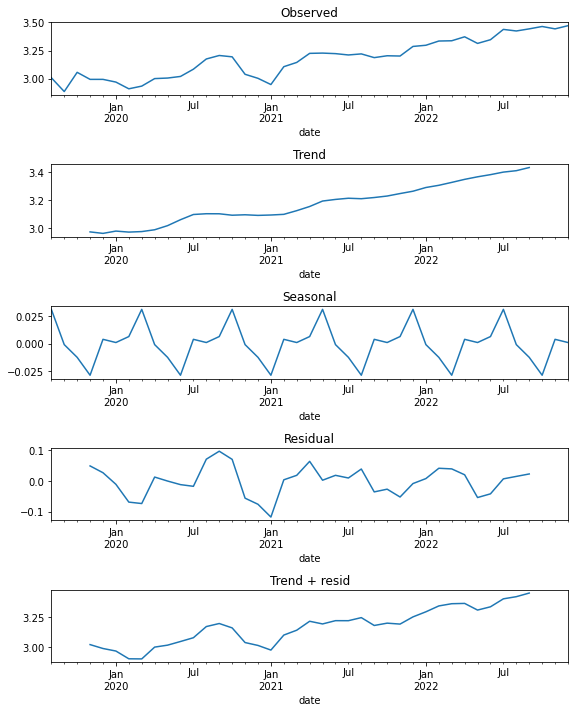

In [242]:
# cfip = 19049
cfip = cfips[0]
# for cfip in cfips: 
location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
sample = mbd_data[ mbd_data.cfips == cfip].microbusiness_density.values

dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
df = pd.DataFrame([dates,sample]).T
df.columns = ["date", "mbd"]
df.set_index('date',inplace=True)
result = seasonal_decompose(df, model='additive',period=7)
# result.seasonal.values, result.resid.values

# plot the decomposition components
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(5, 1, figsize=(8, 10))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
(result.resid + result.trend).plot(ax=ax5, title='Trend + resid')
plt.tight_layout()
plt.show()

### Benchmarking with Linear Regression

In [167]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [166]:
columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]
X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns]
# y_cur = mbd_data[ y.cfips == cfip ].loc[:,"microbusiness_density"]
y_cur = result.observed - result.seasonal
model = LinearRegression()
model.fit(X_cur,y_cur)
y_pred = np.maximum(0,model.predict(X_cur))

In [170]:
smape(y_cur + result.seasonal.values, y_pred + result.seasonal.values)

0.0070546925214427

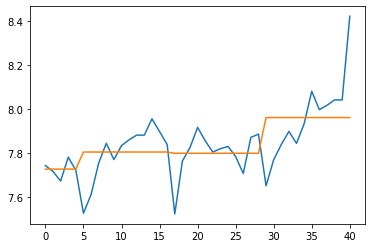

In [177]:
plt.plot(y_cur.values)
plt.plot(y_pred)

In [396]:
good_performing_counties = []
errors = []
for cfip in tqdm(cfips): 
    columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]
    X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns]
    time_steps = list( range(len(X_cur)))
    X_cur.insert(0, "time_step", time_steps) 
    y_cur = mbd_data[ mbd_data.cfips == cfip ].loc[:,"microbusiness_density"]
    
    X_train, X_test, y_train, y_test = train_test_split(X_cur, y_cur, test_size=0.1, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_smape = smape(y_train_pred, y_train)

    y_test_pred = model.predict(X_test)
    test_smape = smape(y_test_pred, y_test)

    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))

    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))
    
    if test_smape < 0.02 : 
        good_performing_counties.append(cfip)
    else: 
        X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns][-15:]
        time_steps = list( range(len(X_cur)))
        X_cur.insert(0, "time_step", time_steps) 
        y_cur = mbd_data[ mbd_data.cfips == cfip ].loc[:,"microbusiness_density"][-15:]

        X_train, X_test, y_train, y_test = train_test_split(X_cur, y_cur, test_size=0.05, shuffle=False)
        model = LinearRegression()
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_smape = smape(y_train_pred, y_train)

        y_test_pred = model.predict(X_test)
        test_smape = smape(y_test_pred, y_test)

        y_train_pred = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))

        y_test_pred = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))
        
        if test_smape < 0.02 : 
            good_performing_counties.append(cfip)
        
    errors.append(test_smape)
errors = np.array(errors)
print(len(good_performing_counties))
        

100%|██████████████████████████████████████████████████████████████████████████████| 3135/3135 [01:26<00:00, 36.09it/s]

2294


In [401]:
updated_clusters = {}
for key in cluster_keys:
    updated_clusters[str(key)] = [cfip for cfip in clusters[key] if not (cfip in good_performing_counties)]

In [404]:
len(updated_clusters["-1"])

173

In [399]:
len(clusters["0"])

2527

In [409]:
len(good_performing_counties) , len(cfips) , len(good_performing_counties) - len(cfips) 

(2294, 3135, -841)

In [180]:
# Fit sarima model 

In [221]:
# specify SARIMA model order and seasonal order
order = (0, 0, 0) # (p, d, q) order of non-seasonal component
seasonal_order = (0, 1, 0, 12) # (P, D, Q, S) order of seasonal component

# create SARIMA model object and fit to data
model = SARIMAX(result.seasonal.values, order=order, seasonal_order=seasonal_order)
results = model.fit()

C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [243]:
# results.summary()

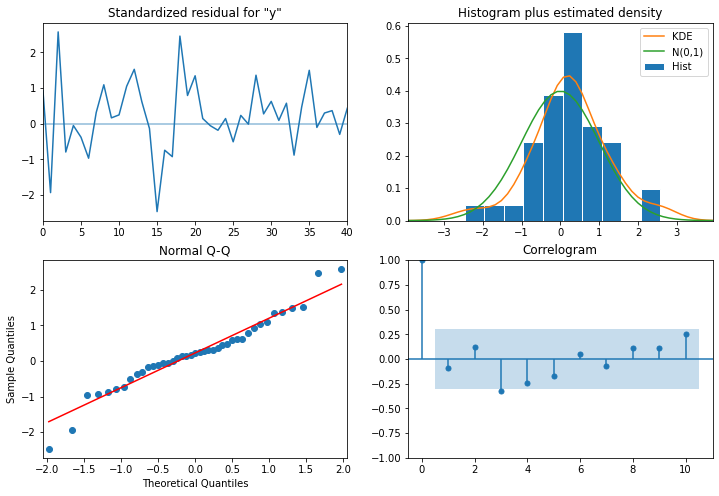

In [410]:
# plot model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

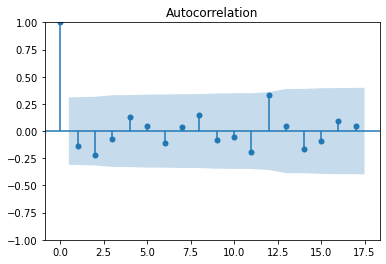

In [218]:
plot_acf(y_cur.diff(1)[1:])
plt.show()

0.03687913728806737


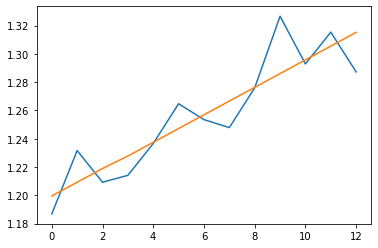

In [403]:
# Make predictions 


cfip = updated_clusters["0"][0]
# columns = ["pct_bb","median_hh_inc","pct_college", "pct_foreign_born","pct_it_workers"]
columns =["pct_bb"]
X_cur = mbd_data[mbd_data.cfips == cfip].loc[:,columns][-15:]
time_steps = list( range(len(X_cur)))
X_cur.insert(0, "time_step", time_steps) 
y_cur = mbd_data[ mbd_data.cfips == cfip ].loc[:,"microbusiness_density"][-15:]

X_train, X_test, y_train, y_test = train_test_split(X_cur, y_cur, test_size=0.1, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
train_smape = smape(y_train_pred, y_train)

y_test_pred = model.predict(X_test)
test_smape = smape(y_test_pred, y_test)

y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))

y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))

print(test_smape)

plt.plot(y_train.values)
plt.plot(y_train_pred)

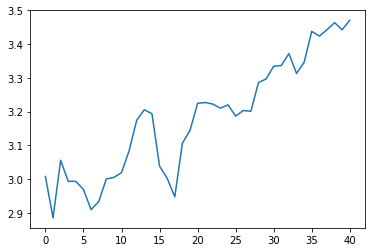

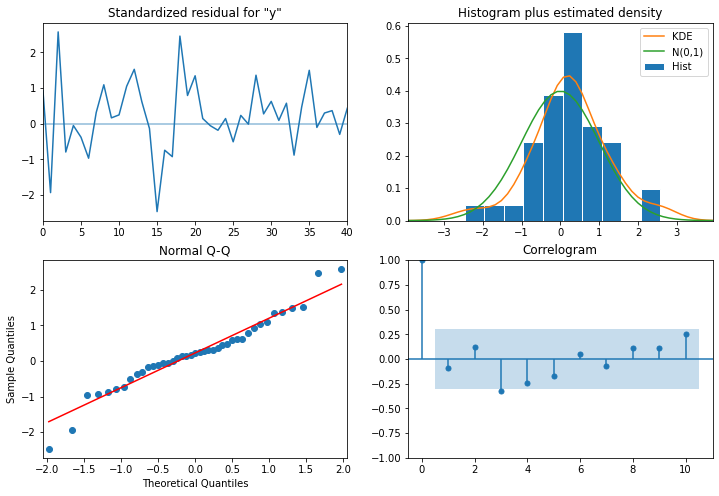

In [375]:
# Counties to investigate

cfip = updated_clusters["0"][0]

# specify SARIMA model order and seasonal order
order = (1, 0, 1) # (p, d, q) order of non-seasonal component
seasonal_order = (0, 0, 0, 1) # (P, D, Q, S) order of seasonal component

# create SARIMA model object and fit to data
y = mbd_data[ mbd_data.cfips == cfip ].microbusiness_density.values

model = LinearRegression()
plt.plot(y)
plt.show()
# model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
# results = model.fit()

# plot model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()


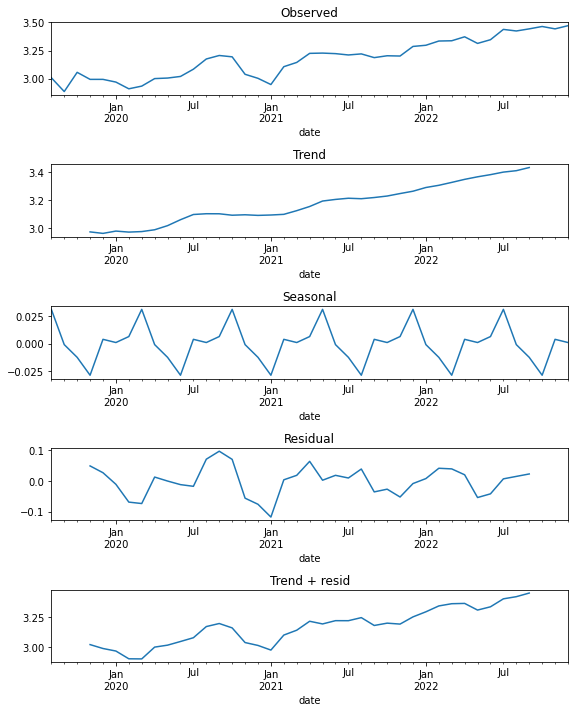

In [362]:
# cfip = 19049
cfip = cfips[0]
# for cfip in cfips: 
location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
sample = mbd_data[ mbd_data.cfips == cfip].microbusiness_density.values

dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
df = pd.DataFrame([dates,sample]).T
df.columns = ["date", "mbd"]
df.set_index('date',inplace=True)
result = seasonal_decompose(df, model='additive',period=7)
# result.seasonal.values, result.resid.values

# plot the decomposition components
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(5, 1, figsize=(8, 10))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
(result.resid + result.trend).plot(ax=ax5, title='Trend + resid')
plt.tight_layout()
plt.show()

In [353]:
# Classify counties in 2 broad categories 

# one which becomes consistant after lockdown , others which don't become consistant after lockdown

In [355]:
mbd_data[ mbd_data.cfips == cfip ].microbusiness_density.values

array([3.0076818, 2.8848701, 3.0558431, 2.9932332, 2.9932332, 2.96909  ,
       2.9093256, 2.9332314, 3.0001674, 3.0049484, 3.0192919, 3.0838373,
       3.174679 , 3.2057564, 3.1938035, 3.0384164, 3.002558 , 2.9472437,
       3.1061056, 3.1440427, 3.2246592, 3.2270303, 3.2222881, 3.2104328,
       3.2199171, 3.186722 , 3.2033195, 3.2009485, 3.2863071, 3.2967808,
       3.3344314, 3.3367846, 3.372082 , 3.3132529, 3.3461974, 3.4379706,
       3.4238517, 3.442677 , 3.4638555, 3.442677 , 3.4709148])

### ARIMA Model 